#### Import libraries

In [2]:
import pandas as pd
import math
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.io as pio

In [3]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [4]:
# Select country in analysys ('FIN', 'DEN', 'NOR', 'SWE')
country = 'DEN'

### Load Data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '2.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index  
df = df.set_index("Date").asfreq('MS')

In [6]:
# Dependant variable
dep_var = 'Orders'     

In [7]:
df

,Orders,CPI,UR,LTIR,Orders_rolled_detrended,Orders_lagged_12m
Date,,,,,,
2007-01-01,331,1.781473,4.1,3.996,-91.083333,161
2007-02-01,299,1.882353,3.9,4.054,-127.166667,250
2007-03-01,378,1.992966,3.7,3.958,-40.666667,468
2007-04-01,267,1.633606,3.5,4.182,-139.583333,412
2007-05-01,337,1.748252,3.6,4.336,-51.833333,550
...,...,...,...,...,...,...
2022-08-01,343,8.909952,4.5,1.375,23.750000,232
2022-09-01,337,10.018900,4.6,2.200,18.666667,348
2022-10-01,322,10.112360,4.6,2.599,13.000000,434


### Split Data

In [8]:
steps = 36  # 36 months of testing
train = df[:-steps]
test  = df[-steps:]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=192)
Train dates    : 2007-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=156)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


### Scoring function

In [9]:
metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):
    
    mae = np.mean(np.abs(y_pred - y_true))                                    # MAE
    mse = mean_squared_error(y_true, y_pred)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                     # RMSE (Root Mean Squared Error)    
    r2 = r2_score(y_true, y_pred)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)*100)                # MAPE        
    accuracy = 100 - mape                                                     # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']       

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy                    
    
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions - " + country)    

        fig.show()  

                    

### Modeling

#### Simple Exponential Smoothing

Simple Exponential Smoothing Model Performance:
Mean Absolute Error: 374.55.
Mean Squared Error: 169685.48.
Root Mean Squared Error: 411.93.
R^2 Score = -2.31.
Mean Absolute Percentage Error: 128.57%.
Accuracy = -28.57%.


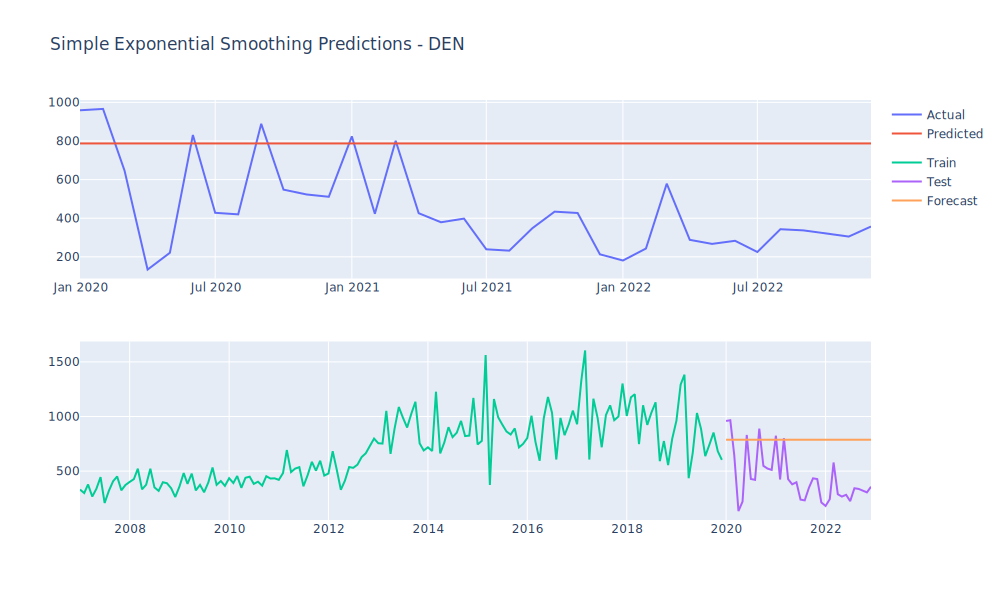

In [10]:
model_name='Simple Exponential Smoothing'
span = 12
alpha = 2/(span+1)

# Train
model = SimpleExpSmoothing(train[dep_var]).fit(smoothing_level=alpha,optimized=False)

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Double Explonential Smoothing

Double Exponential Smoothing Model Performance:
Mean Absolute Error: 288.55.
Mean Squared Error: 98992.43.
Root Mean Squared Error: 314.63.
R^2 Score = -0.93.
Mean Absolute Percentage Error: 98.83%.
Accuracy = 1.17%.


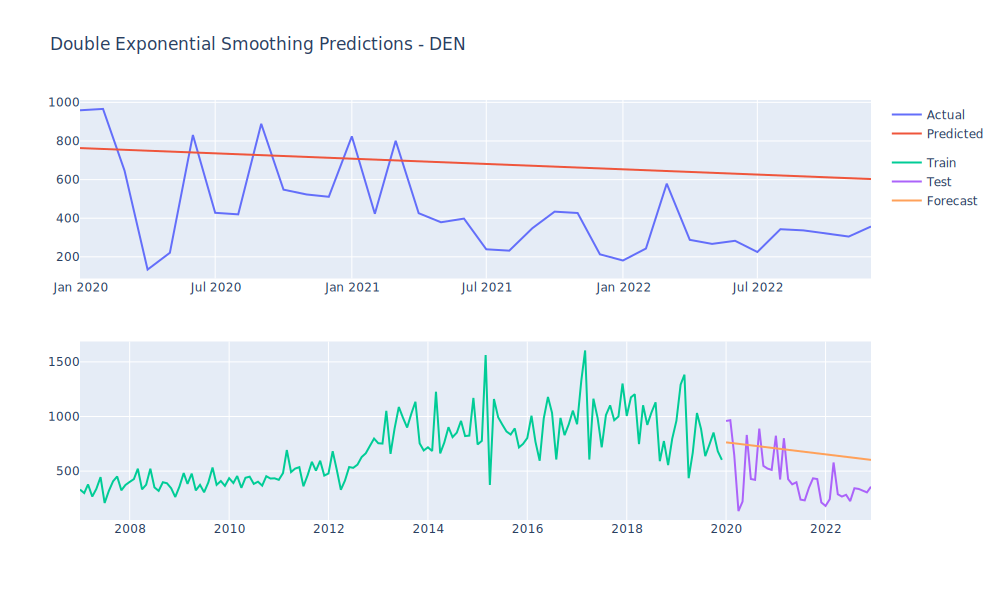

In [11]:
model_name='Double Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal_periods=12).fit()
# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Triple Exponential Smoothing

Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 400.50.
Mean Squared Error: 200168.54.
Root Mean Squared Error: 447.40.
R^2 Score = -2.91.
Mean Absolute Percentage Error: 130.89%.
Accuracy = -30.89%.


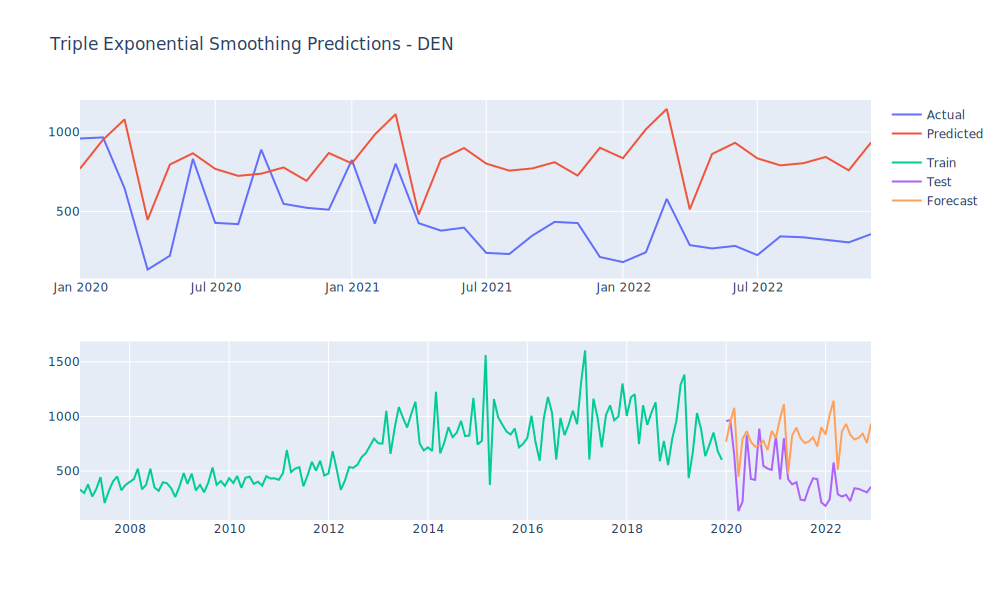

In [12]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [13]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing
Mean Absolute Error,374.545492,288.545607,400.502355
Mean Squared Error,169685.476561,98992.434108,200168.540882
Root Mean Squared Error,411.928970,314.630631,447.401990
R^2,-2.312484,-0.932463,-2.907554
Mean Absolute Percentage Error,128.569802,98.833540,130.888264
Accuracy,-28.569802,1.166460,-30.888264


#### ARIMA

In [14]:
#Standard ARIMA Model
model = auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2070.942, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2158.758, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2118.713, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2069.855, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2156.766, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2070.603, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2072.004, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2069.128, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2070.036, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2069.603, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2116.742, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2071.355, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.853 seconds


In [15]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1032.564
Date:                Wed, 15 Feb 2023   AIC                           2069.128
Time:                        17:07:56   BIC                           2075.214
Sample:                    01-01-2007   HQIC                          2071.600
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8219      0.034    -24.238      0.000      -0.888      -0.755
sigma2      3.554e+04   2784.198     12.766      0.000    3.01e+04     4.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):                37.92
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):              10.12   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA Model Performance:
Mean Absolute Error: 364.70.
Mean Squared Error: 159735.58.
Root Mean Squared Error: 399.67.
R^2 Score = -2.12.
Mean Absolute Percentage Error: 124.91%.
Accuracy = -24.91%.


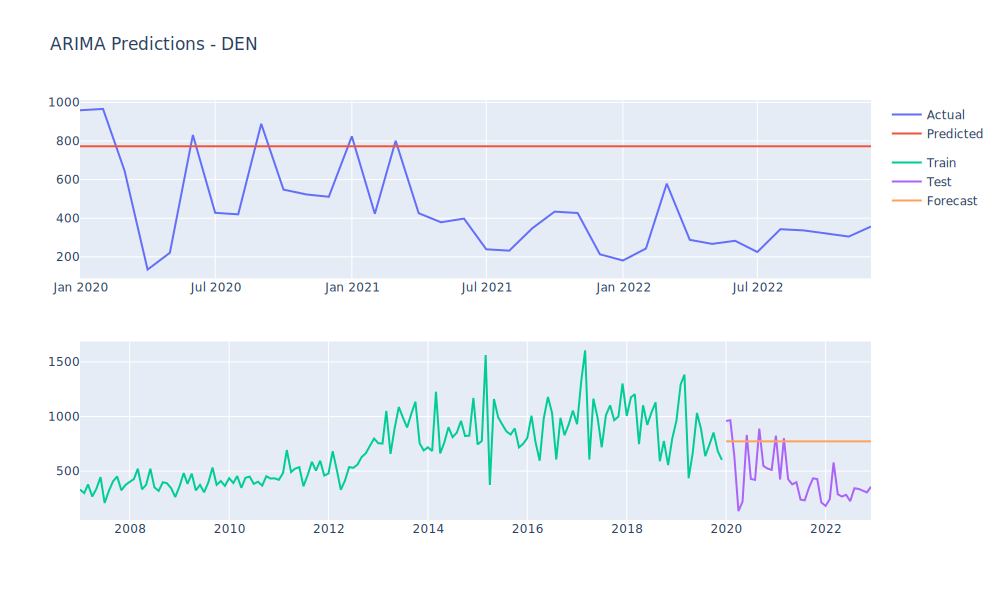

In [17]:
model_name='ARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [18]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA
Mean Absolute Error,374.545492,288.545607,400.502355,364.697824
Mean Squared Error,169685.476561,98992.434108,200168.540882,159735.582476
Root Mean Squared Error,411.928970,314.630631,447.401990,399.669341
R^2,-2.312484,-0.932463,-2.907554,-2.118249
Mean Absolute Percentage Error,128.569802,98.833540,130.888264,124.906428
Accuracy,-28.569802,1.166460,-30.888264,-24.906428


#### SARIMA

In [19]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1901.624, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1974.605, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1929.199, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1925.841, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1977.449, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1962.269, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1902.315, Time=1.44 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1902.207, Time=3.19 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1911.979, Time=1.12 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1919.698, Time=0.62 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1903.558, Time=1.60 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1903.540, Time=1.26 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1938.265, Time=0.34 sec
 ARIMA(0,0,2)(0,1,1)[12]

In [20]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -943.808
Date:                            Wed, 15 Feb 2023   AIC                           1897.616
Time:                                    17:08:44   BIC                           1912.465
Sample:                                01-01-2007   HQIC                          1903.650
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9801      0.019     51.499      0.000       0.943       1.017
ma.L1         -0.7607      0.062    -12.180      0.000      -0.883      -0.638
ar.S.L12      -0.2732      0.107     -2.558      0.011      -0.483      -0.064
ma.S.L12      -0.5483      0.092     -5.988      0.000      -0.728      -0.369
sigma2      2.733e+04   2670.813     10.233      0.000    2.21e+04    3.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 9.69
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               9.04   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA Model Performance:
Mean Absolute Error: 333.46.
Mean Squared Error: 144602.14.
Root Mean Squared Error: 380.27.
R^2 Score = -1.82.
Mean Absolute Percentage Error: 108.39%.
Accuracy = -8.39%.


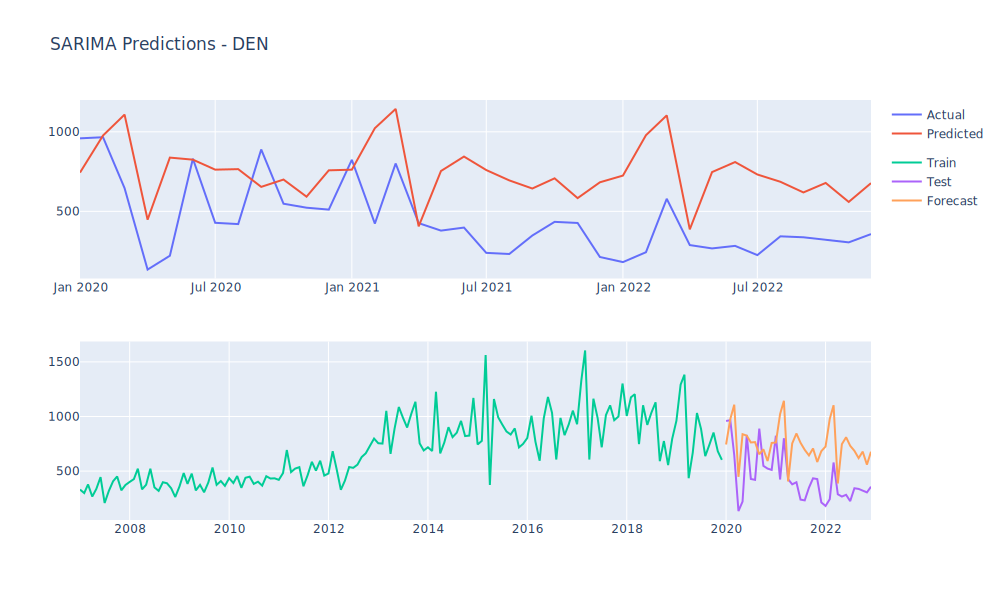

In [22]:
model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [23]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA
Mean Absolute Error,374.545492,288.545607,400.502355,364.697824,333.457051
Mean Squared Error,169685.476561,98992.434108,200168.540882,159735.582476,144602.135054
Root Mean Squared Error,411.928970,314.630631,447.401990,399.669341,380.265874
R^2,-2.312484,-0.932463,-2.907554,-2.118249,-1.822824
Mean Absolute Percentage Error,128.569802,98.833540,130.888264,124.906428,108.390273
Accuracy,-28.569802,1.166460,-30.888264,-24.906428,-8.390273


#### SARIMAX

In [24]:
# SARIMAX = SARIMA with exogenous variable
exo_var = 'CPI'
model = auto_arima(train[dep_var], exogenous=train[[exo_var]],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1901.624, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1974.605, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1929.199, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1925.841, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1977.449, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1962.269, Time=0.35 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1902.315, Time=1.51 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1902.207, Time=3.42 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1911.979, Time=1.28 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=4.72 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1919.698, Time=0.74 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1903.558, Time=1.98 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1903.540, Time=1.75 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1938.265, Time=0.38 sec
 ARIMA(0,0,2)(0,1,1)[12]

In [25]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -943.808
Date:                            Wed, 15 Feb 2023   AIC                           1897.616
Time:                                    17:09:32   BIC                           1912.465
Sample:                                01-01-2007   HQIC                          1903.650
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9801      0.019     51.499      0.000       0.943       1.017
ma.L1         -0.7607      0.062    -12.180      0.000      -0.883      -0.638
ar.S.L12      -0.2732      0.107     -2.558      0.011      -0.483      -0.064
ma.S.L12      -0.5483      0.092     -5.988      0.000      -0.728      -0.369
sigma2      2.733e+04   2670.813     10.233      0.000    2.21e+04    3.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 9.69
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               9.04   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX Model Performance:
Mean Absolute Error: 350.23.
Mean Squared Error: 155423.23.
Root Mean Squared Error: 394.24.
R^2 Score = -2.03.
Mean Absolute Percentage Error: 114.19%.
Accuracy = -14.19%.


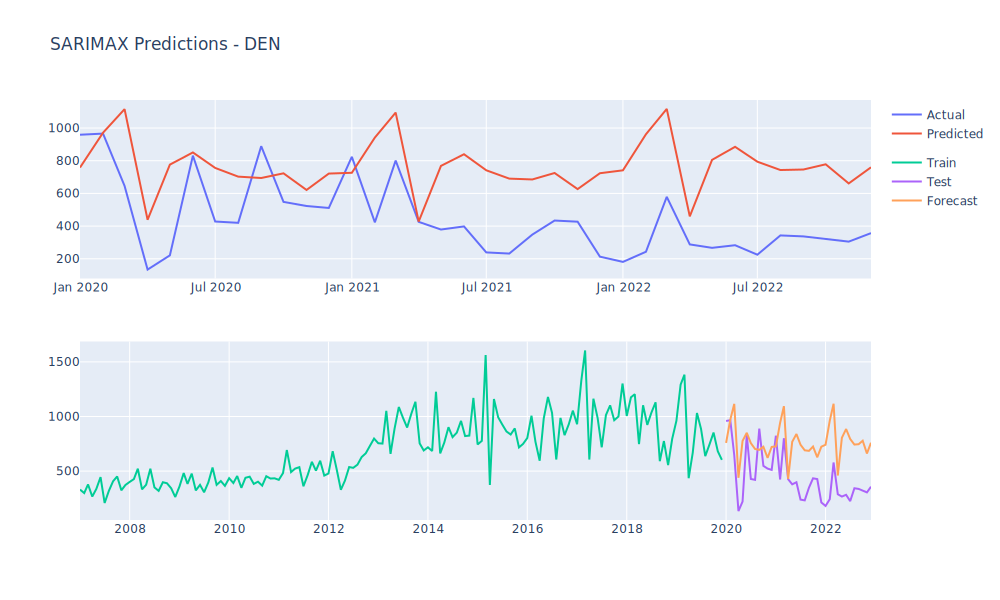

In [27]:
model_name='SARIMAX'

# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12),exog = train[exo_var]).fit()

# Predict
predictions = model.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

### Summary

In [28]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA,SARIMAX
Mean Absolute Error,374.545492,288.545607,400.502355,364.697824,333.457051,350.230140
Mean Squared Error,169685.476561,98992.434108,200168.540882,159735.582476,144602.135054,155423.228349
Root Mean Squared Error,411.928970,314.630631,447.401990,399.669341,380.265874,394.237528
R^2,-2.312484,-0.932463,-2.907554,-2.118249,-1.822824,-2.034066
Mean Absolute Percentage Error,128.569802,98.833540,130.888264,124.906428,108.390273,114.186669
Accuracy,-28.569802,1.166460,-30.888264,-24.906428,-8.390273,-14.186669


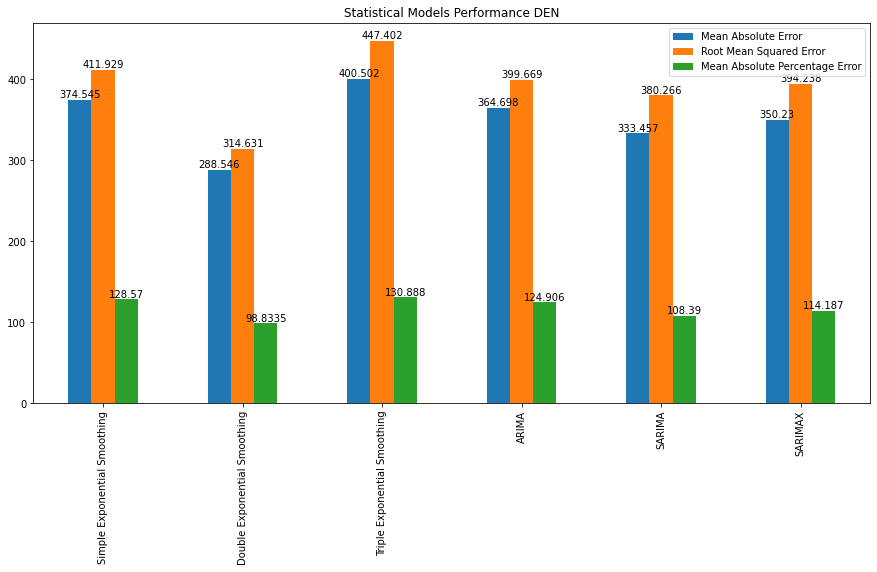

In [29]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="Statistical Models Performance - " + country, figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container)